In [11]:
import torchvision
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader
from torch import optim
import torch.nn as nn
import time


In [12]:
csv_path = './Data/64px Images/train_labels_64p.csv'
root_path = './Data/64px Images'

In [13]:
transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
dataset = ChestImage64(csv_path=csv_path, root_path=root_path, class_name="Lateral", transform=transform)

In [15]:
train_size = round(0.7 * len(dataset))
val_size = round(0.1 * len(dataset))
test_size = round(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


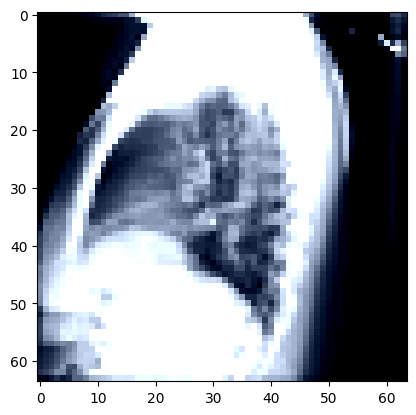

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [16]:
for item in train_loader:
    image = item[0][0].numpy()/2 + 0.5
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()
    print(item[1][0])
    break

In [17]:
model = torchvision.models.resnet152(pretrained=True)
num_classes = 14
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, num_classes)
        )
for param in model.fc.parameters():
    param.requires_grad = True

C:\Users\mhzar\Desktop\Spring 2023\ME 592\Project\Code\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mhzar\Desktop\Spring 2023\ME 592\Project\Code\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
## define the data

optimizer = optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters())

criterion = torch.nn.BCEWithLogitsLoss()

# %%
def train_epoch(model, optimizer, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output,target)

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


# %%
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

N_EPOCHS = 2

start_time = time.time()

model.to(device)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history, device)
    # evaluate(model, test_loader, test_loss_history, device)

Epoch: 1
[    0/21445 (  0%)]  Loss: 0.7417
[ 3200/21445 ( 15%)]  Loss: 0.5722
[ 6400/21445 ( 30%)]  Loss: 0.5065
[ 9600/21445 ( 45%)]  Loss: 0.4226
[12800/21445 ( 60%)]  Loss: 0.5300
[16000/21445 ( 75%)]  Loss: 0.5669
[19200/21445 ( 89%)]  Loss: 0.5262
Epoch: 2
[    0/21445 (  0%)]  Loss: 0.5582
[ 3200/21445 ( 15%)]  Loss: 0.4778
[ 6400/21445 ( 30%)]  Loss: 0.4087
[ 9600/21445 ( 45%)]  Loss: 0.5852
[12800/21445 ( 60%)]  Loss: 0.5493
[16000/21445 ( 75%)]  Loss: 0.4245
[19200/21445 ( 89%)]  Loss: 0.4758


In [22]:
def multi_class_multi_label_accuracy(y_pred, y_true, threshold=0.5):
    # Apply sigmoid function to raw outputs
    y_pred = torch.sigmoid(y_pred)

    # Threshold the predictions
    y_pred = (y_pred > threshold).float()
    # Compute accuracy
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / (y_true.numel())

    return accuracy


In [23]:
# Import torch and the accuracy function
import torch
total_accuracy  = []
for input, target in test_loader:
    # Compute multi-class multi-label accuracy
    y_pred = model(input)
    accuracy = multi_class_multi_label_accuracy(y_pred, target, threshold=0.5)
    total_accuracy.append(accuracy.item())

print("Accuracy: {:.2f}".format((np.mean(total_accuracy))))


Accuracy: 0.75


In [24]:
total_accuracy

[0.8147321343421936,
 0.7477678656578064,
 0.7723214030265808,
 0.7098214030265808,
 0.6785714030265808,
 0.7410714030265808,
 0.7544642686843872,
 0.78125,
 0.796875,
 0.7991071343421936,
 0.7455357313156128,
 0.7165178656578064,
 0.7946428656578064,
 0.7857142686843872,
 0.7991071343421936,
 0.765625,
 0.7901785969734192,
 0.8169642686843872,
 0.7700892686843872,
 0.7120535969734192,
 0.7433035969734192,
 0.7522321343421936,
 0.7120535969734192,
 0.7120535969734192,
 0.78125,
 0.6986607313156128,
 0.7366071343421936,
 0.6941964030265808,
 0.7455357313156128,
 0.7544642686843872,
 0.7745535969734192,
 0.7321428656578064,
 0.7455357313156128,
 0.7477678656578064,
 0.75,
 0.7276785969734192,
 0.7566964030265808,
 0.7879464030265808,
 0.7767857313156128,
 0.7299107313156128,
 0.7790178656578064,
 0.7388392686843872,
 0.78125,
 0.7321428656578064,
 0.7165178656578064,
 0.7522321343421936,
 0.7388392686843872,
 0.7834821343421936,
 0.7767857313156128,
 0.7901785969734192,
 0.78348213434219

In [189]:
for item in train_loader:
    X = item[0][0:32]
    Y = item[1][0:32]
    break

In [190]:
Y

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0

In [208]:
N = 15
n = 32
lambdas = torch.linspace(0,1,N) # N can be taken to infinity without penalty
losses = torch.zeros((n,N)) # loss for example i with parameter lambdas[j]

In [209]:
alpha, delta = 0.4 , 0.2
for i in range(n): # In reality we parallelize these loops massively
    sigmoids = model(X[i].unsqueeze(0)).sigmoid().squeeze() # Care with dims
    for j in range(N):
        T = sigmoids > lambdas[j] # This is the prediction set
        set_size = T.float().sum()
        if set_size != 0:
            true_label = Y[i].nonzero(as_tuple=True)[0]
            losses[i,j] = 1 - (T[true_label] == True).float().sum()/set_size



In [210]:
risk = losses.mean(dim=0)
pvals = torch.exp(-2*n*(torch.relu(alpha-risk)**2)) # Or the HB p-value
# Fixed-sequence test starting at lambdas[-1] and ending at lambdas[0]
below_delta = (pvals <= delta).float()
valid = torch.tensor([(below_delta[j:].mean() == 1) for j in range(N)])
lambda_hat = lambdas[valid]

In [211]:
lambda_hat

tensor([0.4286, 0.5000, 0.5714, 0.6429, 0.7143, 0.7857, 0.8571, 0.9286, 1.0000])